# Simulación de errores Pauli en el Algoritmo de Grover

## Funciones usadas

In [4]:
import numpy as np
from qiskit import QuantumCircuit,QuantumRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
import math
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

In [5]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

In [12]:
def add_pauli_error(noiseModel,pbitflip,pphaseflip,gates):
    error = pauli_error([('X',pbitflip),('Z',pphaseflip),('I',1-pbitflip-pphaseflip)])
    #print(error)
    
    noiseModel.add_all_qubit_quantum_error(error,gates)
    return noiseModel

def add_controlled_pauli_error(noiseModel,pbitflip,pphaseflip,gates):
    error = pauli_error([('X',pbitflip),('Z',pphaseflip),('I',1-pbitflip-pphaseflip)])
    noError = pauli_error([('I',1)])
    totalErrorCase = noError.tensor(error)
    #print(totalErrorCase)
    
    noiseModel.add_all_qubit_quantum_error(totalErrorCase,gates)
    return noiseModel


#noise_model = NoiseModel()
#add_pauli_error(noise_model,0.3,0.3,['x','h'])
#add_controlled_pauli_error(noise_model,0.4,0.4,['cx','cz'])

## Errores de Pauli en compuertas de 1 qubit

PROBABILIDAD DE ERROR:  0
noise model:  NoiseModel: Ideal


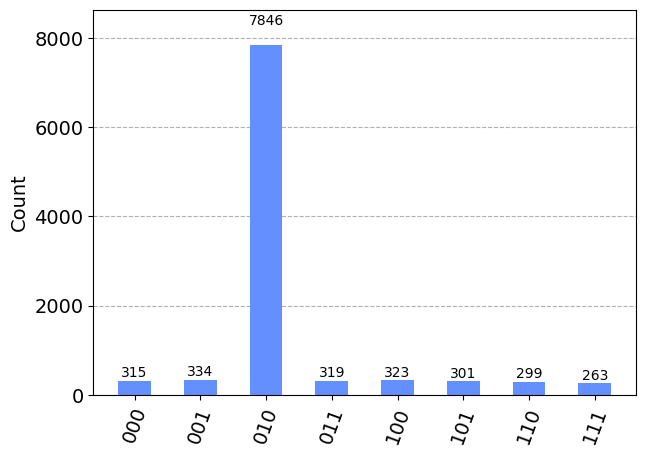

PROBABILIDAD DE ERROR:  0.05
noise model:  NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['h', 'x']
  All-qubits errors: ['x', 'h']


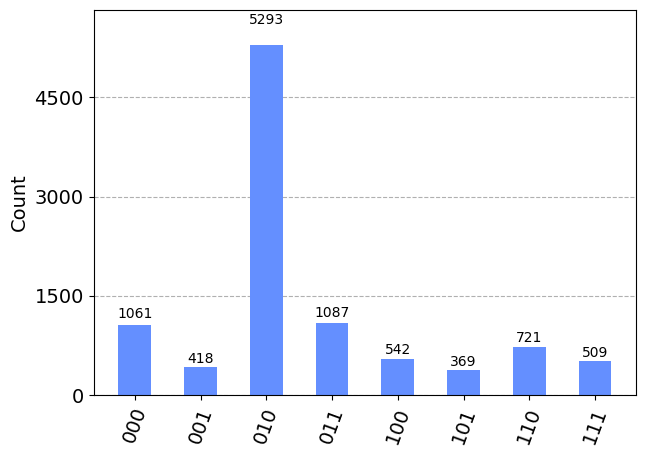

PROBABILIDAD DE ERROR:  0.1
noise model:  NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['h', 'x']
  All-qubits errors: ['x', 'h']


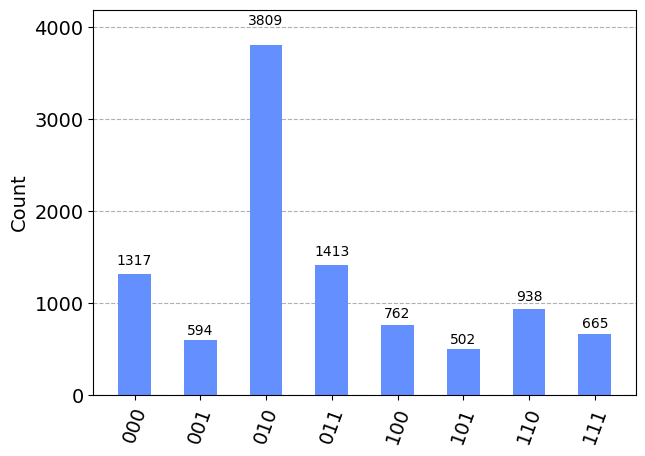

PROBABILIDAD DE ERROR:  0.15
noise model:  NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['h', 'x']
  All-qubits errors: ['x', 'h']


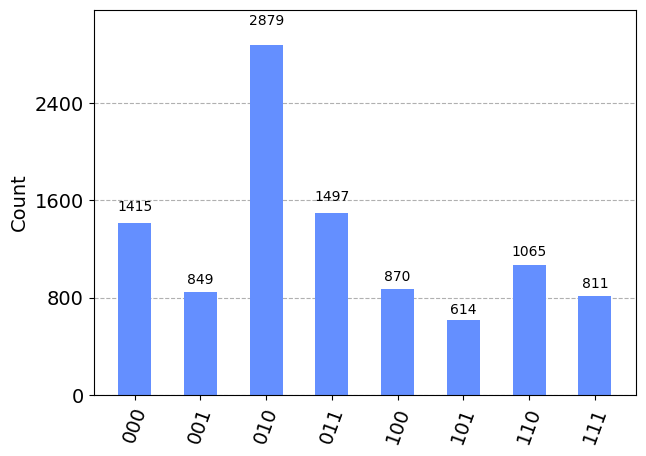

PROBABILIDAD DE ERROR:  0.2
noise model:  NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['h', 'x']
  All-qubits errors: ['x', 'h']


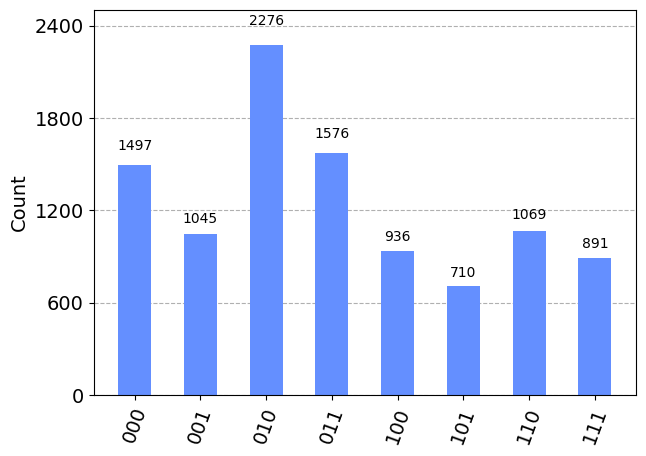

PROBABILIDAD DE ERROR:  0.25
noise model:  NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['h', 'x']
  All-qubits errors: ['x', 'h']


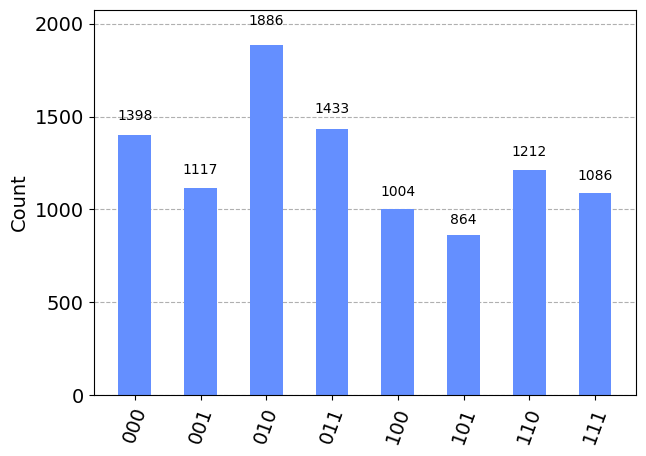

PROBABILIDAD DE ERROR:  0.3
noise model:  NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['h', 'x']
  All-qubits errors: ['x', 'h']


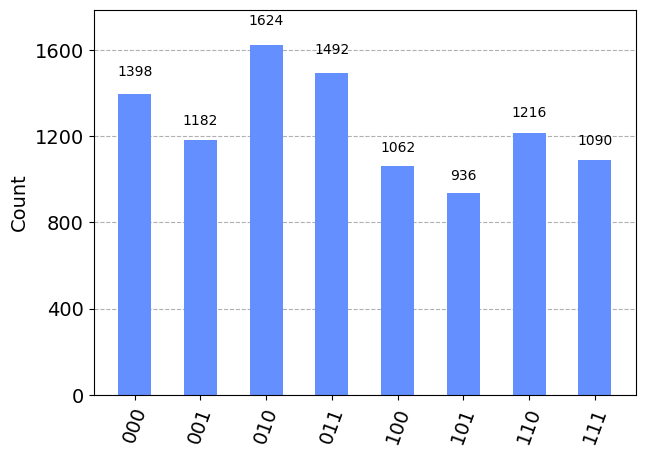

PROBABILIDAD DE ERROR:  0.35
noise model:  NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['h', 'x']
  All-qubits errors: ['x', 'h']


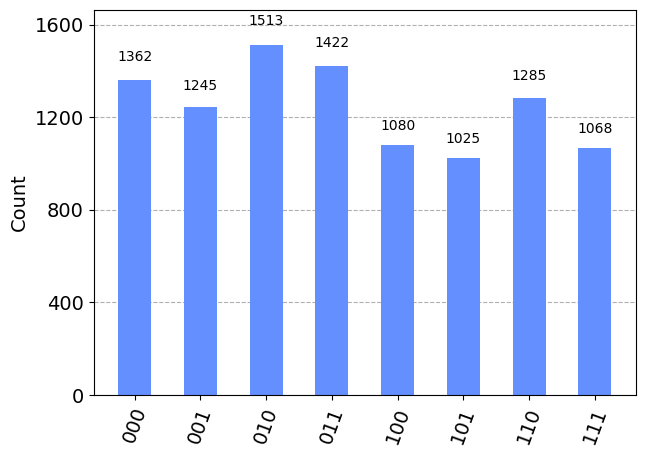

PROBABILIDAD DE ERROR:  0.4
noise model:  NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['h', 'x']
  All-qubits errors: ['x', 'h']


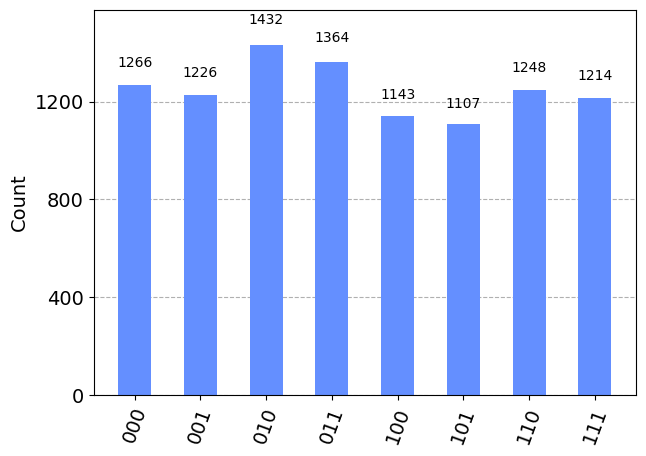

PROBABILIDAD DE ERROR:  0.45
noise model:  NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['h', 'x']
  All-qubits errors: ['x', 'h']


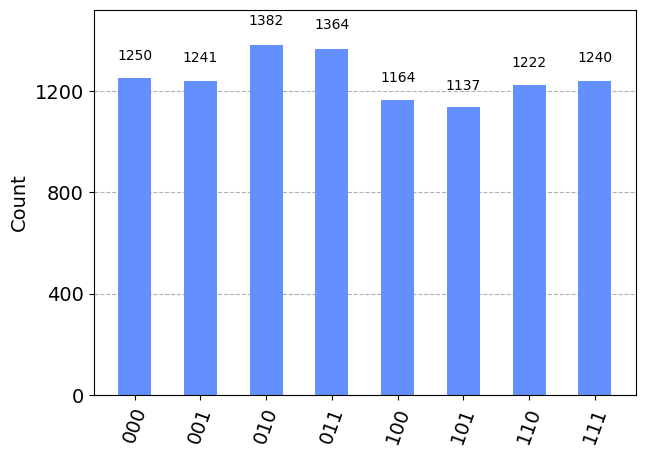

PROBABILIDAD DE ERROR:  0.5
noise model:  NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['h', 'x']
  All-qubits errors: ['x', 'h']


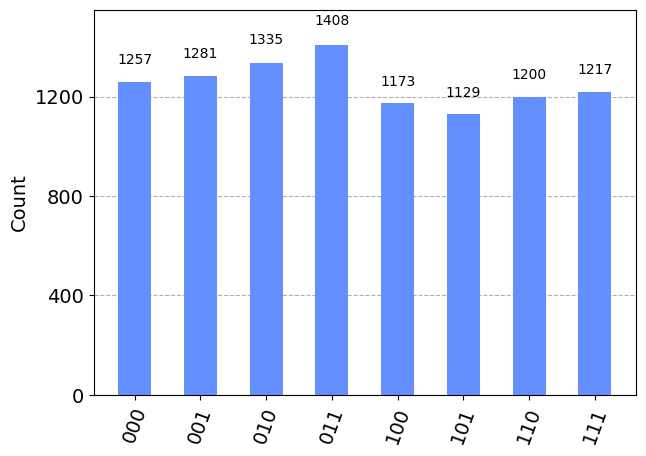

PROBABILIDAD DE ERROR:  0.55
noise model:  NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['h', 'x']
  All-qubits errors: ['x', 'h']


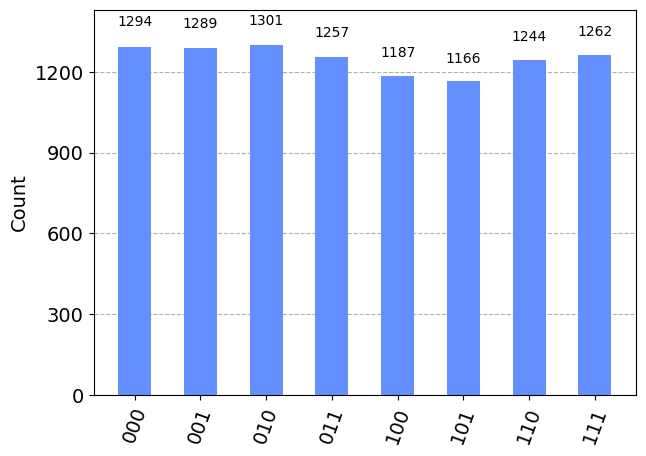

PROBABILIDAD DE ERROR:  0.6
noise model:  NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['h', 'x']
  All-qubits errors: ['x', 'h']


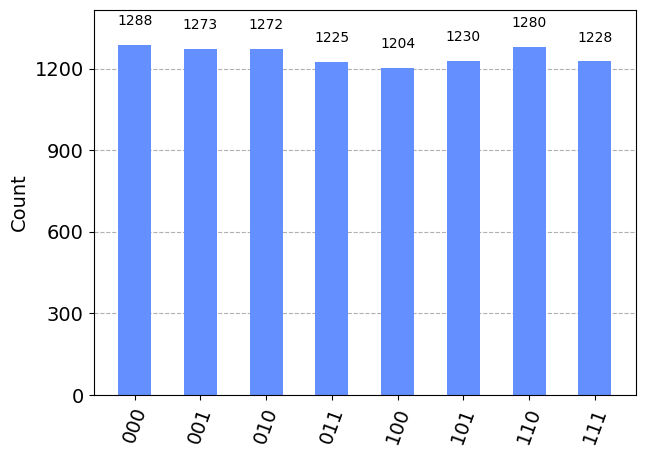

PROBABILIDAD DE ERROR:  0.65
noise model:  NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['h', 'x']
  All-qubits errors: ['x', 'h']


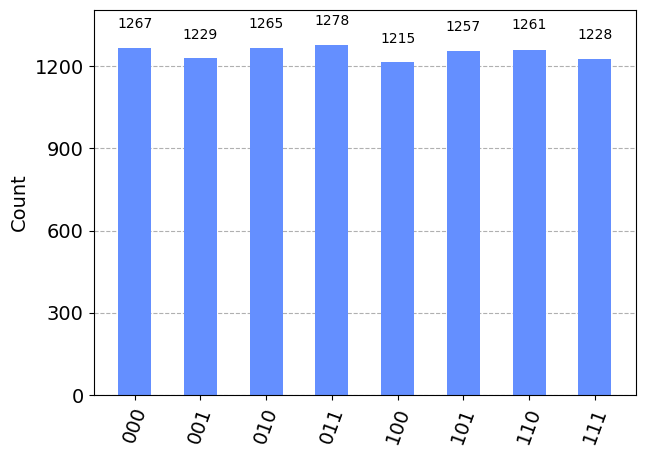

PROBABILIDAD DE ERROR:  0.7
noise model:  NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['h', 'x']
  All-qubits errors: ['x', 'h']


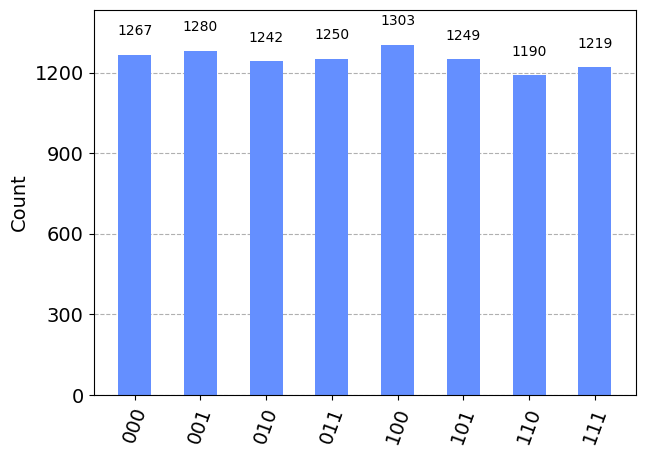

PROBABILIDAD DE ERROR:  0.75
noise model:  NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['h', 'x']
  All-qubits errors: ['x', 'h']


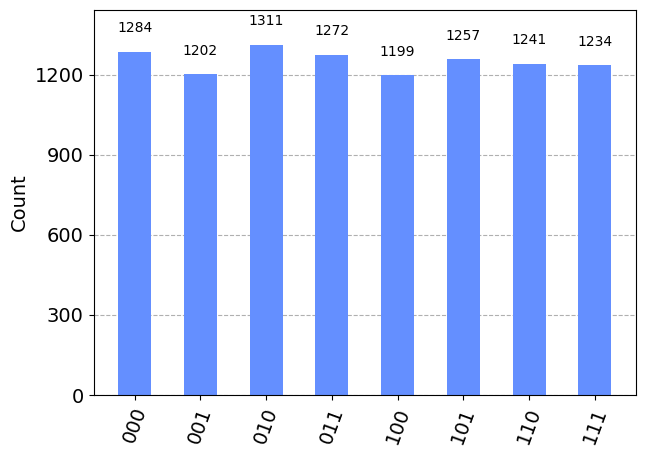

PROBABILIDAD DE ERROR:  0.8
noise model:  NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['h', 'x']
  All-qubits errors: ['x', 'h']


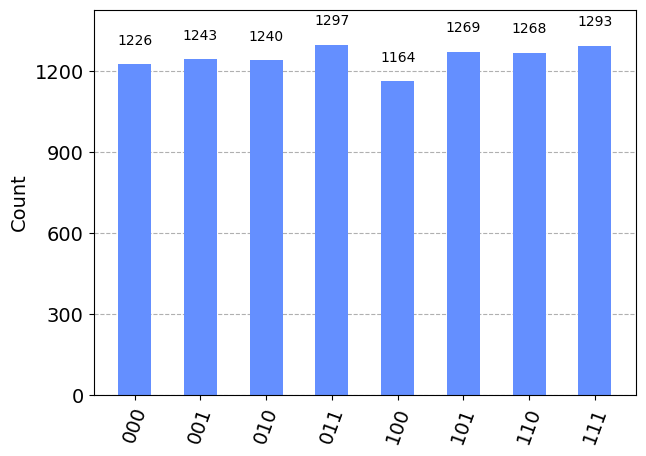

PROBABILIDAD DE ERROR:  0.85
noise model:  NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['h', 'x']
  All-qubits errors: ['x', 'h']


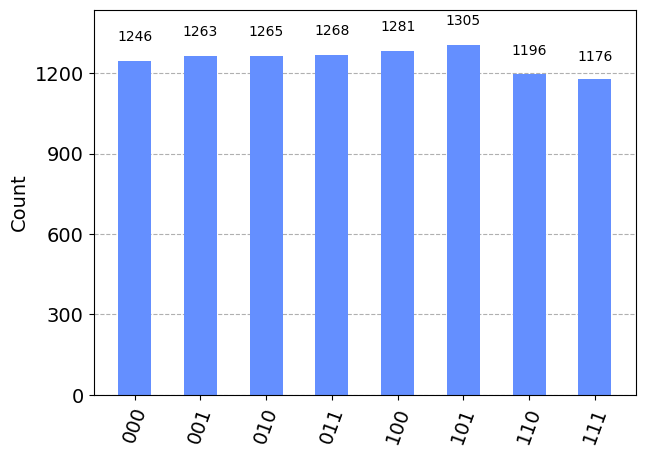

PROBABILIDAD DE ERROR:  0.9
noise model:  NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['h', 'x']
  All-qubits errors: ['x', 'h']


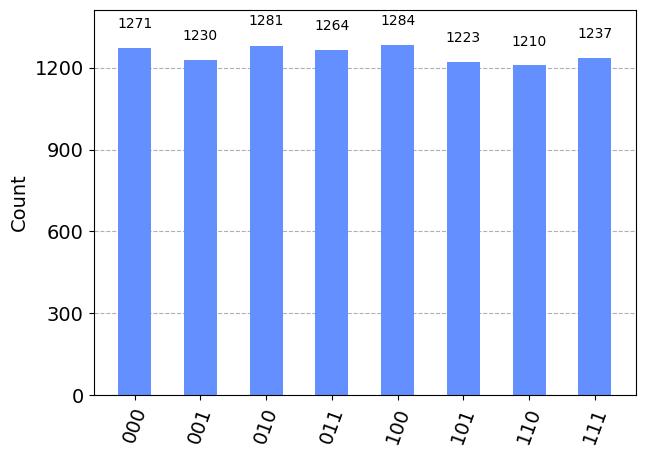

PROBABILIDAD DE ERROR:  0.95
noise model:  NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['h', 'x']
  All-qubits errors: ['x', 'h']


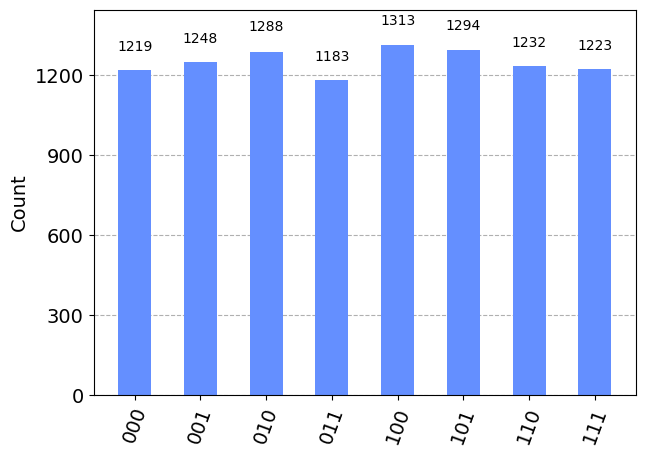

PROBABILIDAD DE ERROR:  1
noise model:  NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['h', 'x']
  All-qubits errors: ['x', 'h']


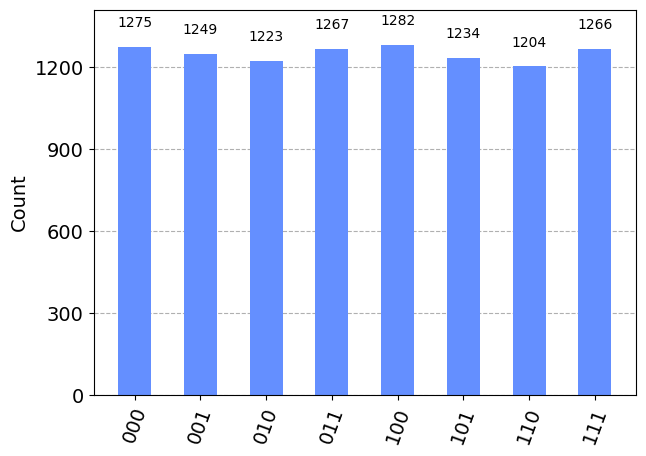

In [7]:
#PREPARACION
marked_states=['010']
nroQubits=3
shots=10000

#Se crea el operador de grover: oraculo + expansion de estado
oracle = grover_oracle(marked_states)
groverOp = GroverOperator(oracle)

#Se calcula el numero optimo de iteraciones
optimal_num_iterations = math.floor(
    math.pi / 4 * math.sqrt(2**groverOp.num_qubits / len(marked_states))
)


errorProbabilities = [
    0,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.35,
    0.4,
    0.45,
    0.5,
    0.55,
    0.6,
    0.65,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    1
]

results = []
for i in errorProbabilities:
    #ALGORITMO
    print('PROBABILIDAD DE ERROR: ',i)
     
    noiseModel = NoiseModel()
    noiseModel = add_pauli_error(noiseModel,i/2,i/2,['x','h'])
    print('noise model: ',noiseModel)
        
    qr = QuantumRegister(nroQubits)
    qc = QuantumCircuit(qr)
    qc.h(qr)
    qc.compose(groverOp.decompose(), inplace=True)
    qc.measure_all()
    #display(qc.draw("mpl"))
    #display(qc.data)
    
    #EJECUCION
    sim_noise = AerSimulator(noise_model=noiseModel)
    circ_tnoise = transpile(qc, sim_noise)
    result_bit_flip = sim_noise.run(circ_tnoise,shots=shots).result()
    counts_bit_flip = result_bit_flip.get_counts(0)
    display(plot_histogram(counts_bit_flip))
        
    results.append(counts_bit_flip)

In [8]:
#CALCULO DE PROBABILIDADES DE EXITO PARA CADA EXPERIMENTO
successCounts=[]
for i in results:
    currentCount = 0
    for j in marked_states:
        currentCount = currentCount + i[j]
    successCounts.append(currentCount/shots)
#print(successCounts)

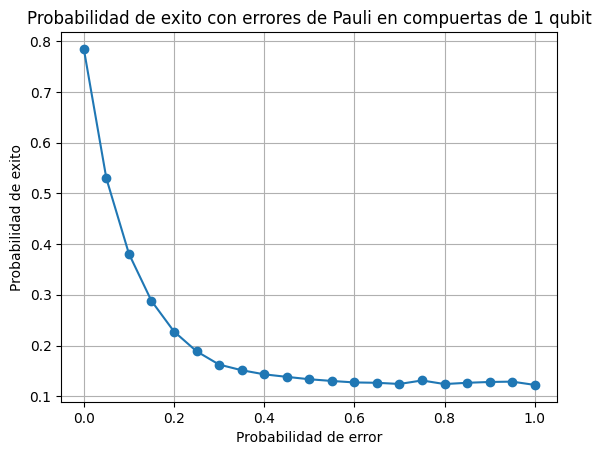

In [9]:
# Crear el gráfico
plt.plot(errorProbabilities, successCounts, marker='o', linestyle='-')

# Etiquetas de los ejes
plt.xlabel('Probabilidad de error')
plt.ylabel('Probabilidad de exito')

# Título del gráfico
plt.title('Probabilidad de exito con errores de Pauli en compuertas de 1 qubit')

# Mostrar el gráfico
plt.grid(True)
plt.show()

## Errores de Pauli en compuertas de 2 qubits

PROBABILIDAD DE ERROR:  0
noise model:  NoiseModel: Ideal


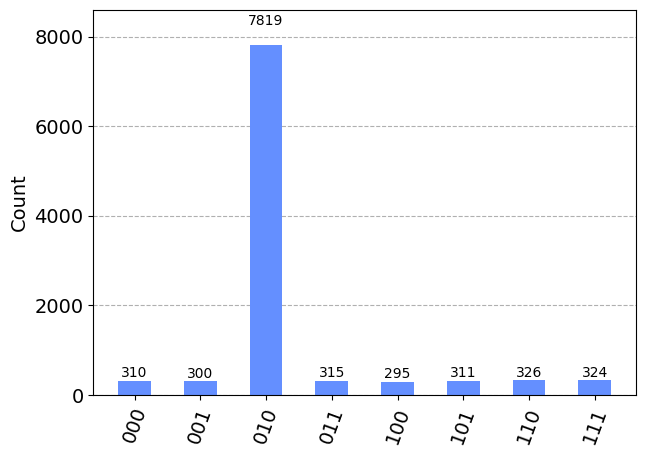

PROBABILIDAD DE ERROR:  0.05
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'cy', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


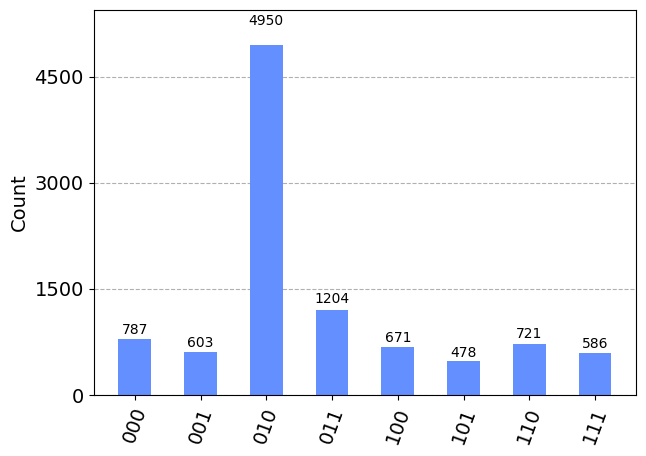

PROBABILIDAD DE ERROR:  0.1
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'cy', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


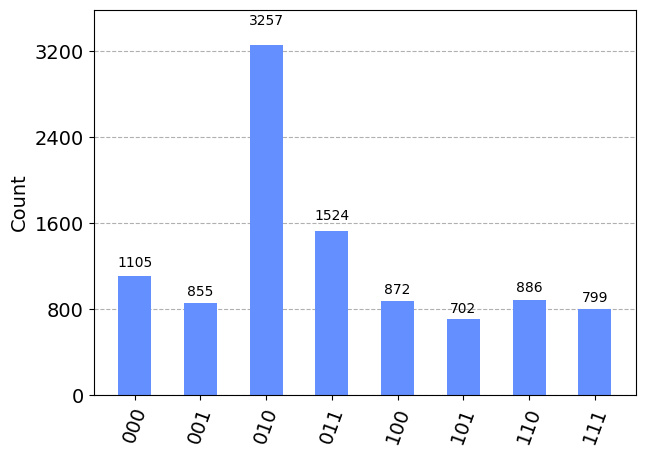

PROBABILIDAD DE ERROR:  0.15
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'cy', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


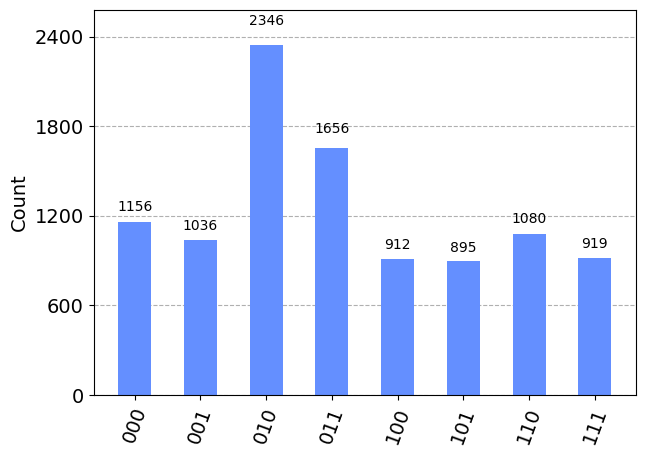

PROBABILIDAD DE ERROR:  0.2
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'cy', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


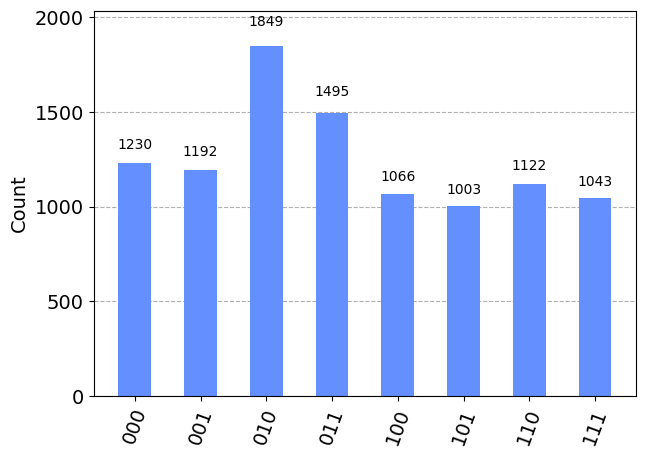

PROBABILIDAD DE ERROR:  0.25
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'cy', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


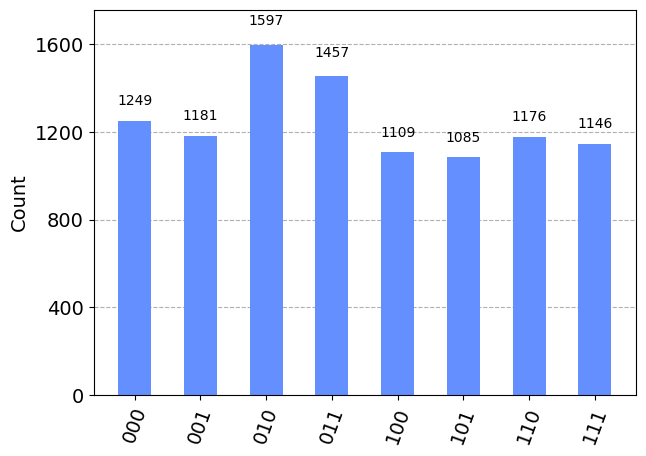

PROBABILIDAD DE ERROR:  0.3
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'cy', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


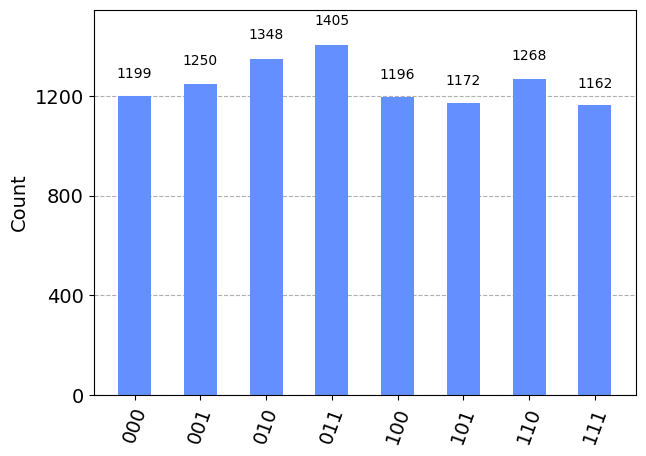

PROBABILIDAD DE ERROR:  0.35
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'cy', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


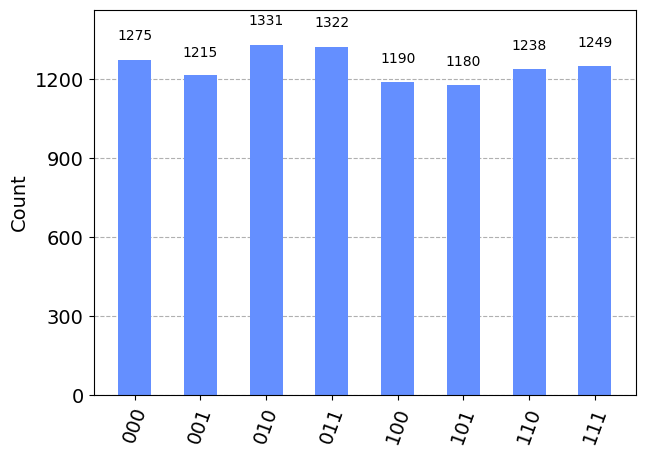

PROBABILIDAD DE ERROR:  0.4
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'cy', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


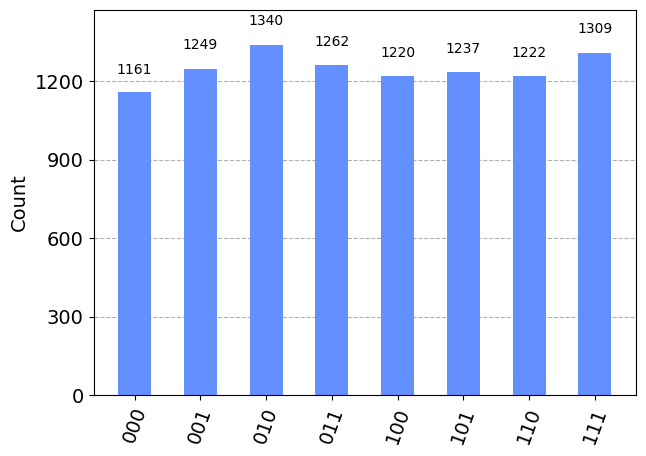

PROBABILIDAD DE ERROR:  0.45
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'cy', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


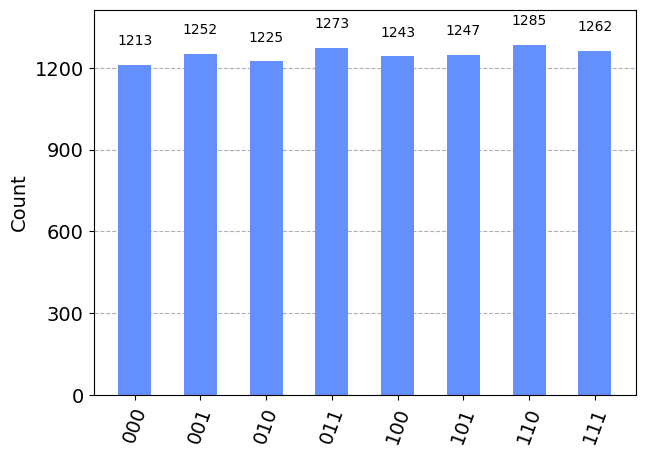

PROBABILIDAD DE ERROR:  0.5
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'cy', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


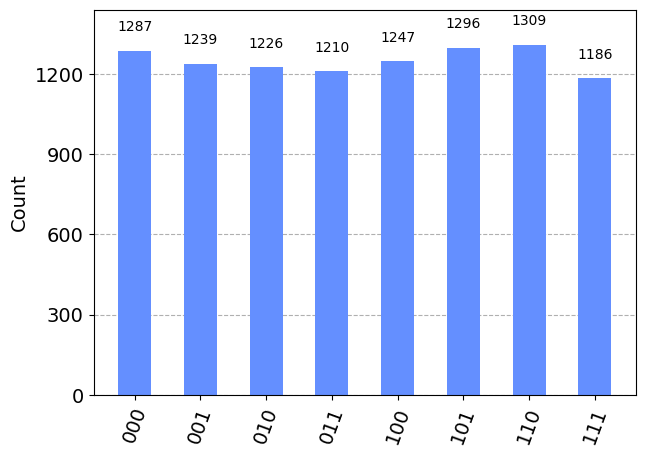

PROBABILIDAD DE ERROR:  0.55
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'cy', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


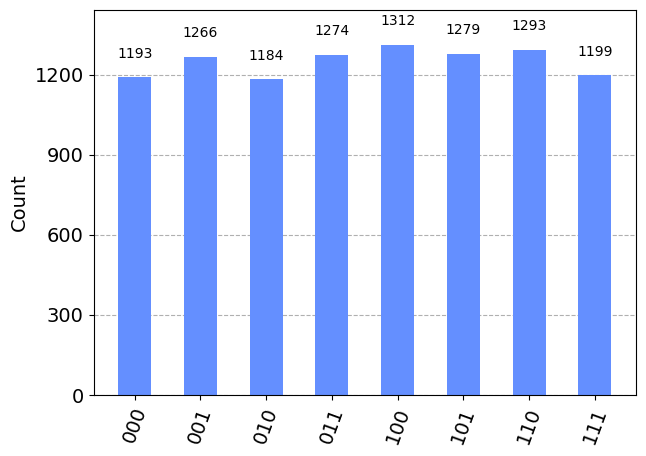

PROBABILIDAD DE ERROR:  0.6
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'cy', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


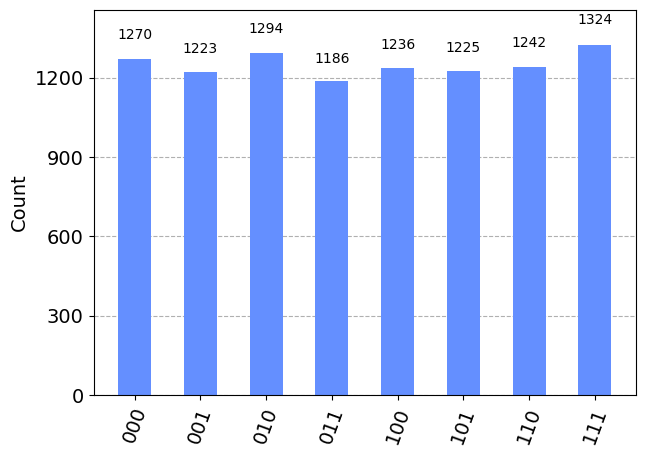

PROBABILIDAD DE ERROR:  0.65
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'cy', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


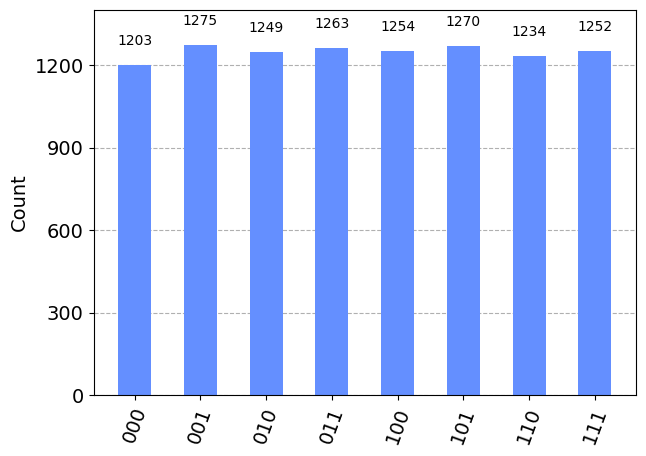

PROBABILIDAD DE ERROR:  0.7
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'cy', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


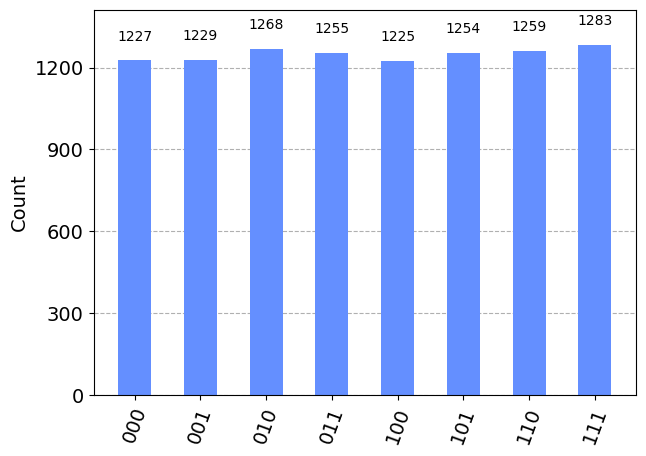

PROBABILIDAD DE ERROR:  0.75
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'cy', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


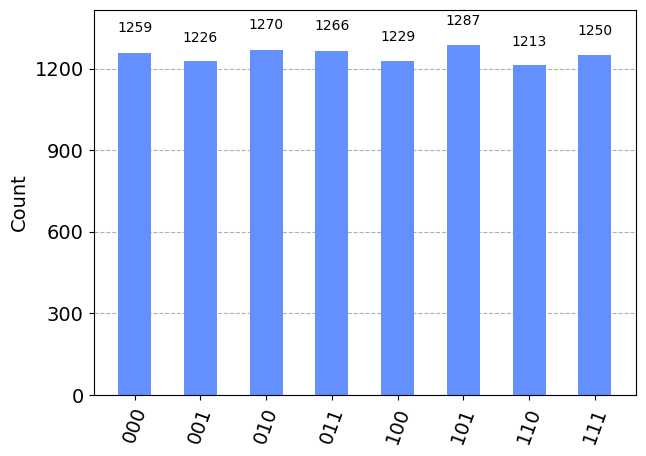

PROBABILIDAD DE ERROR:  0.8
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'cy', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


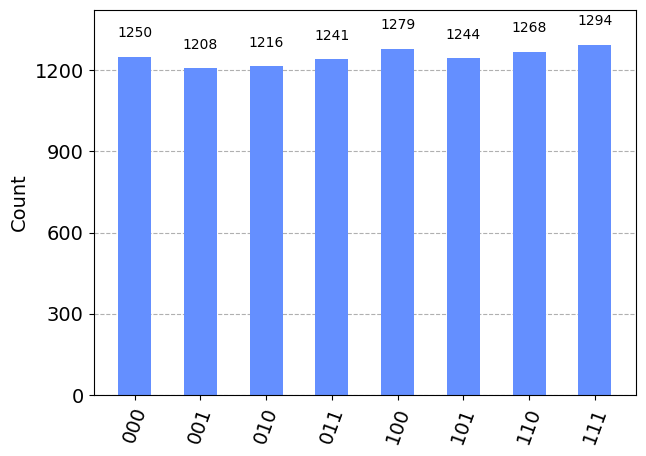

PROBABILIDAD DE ERROR:  0.85
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'cy', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


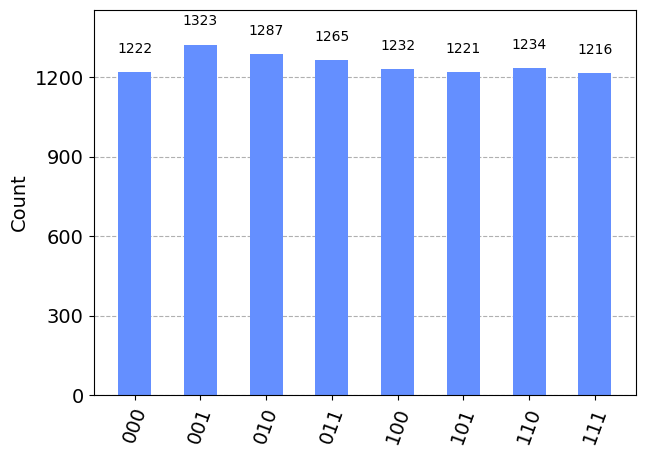

PROBABILIDAD DE ERROR:  0.9
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'cy', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


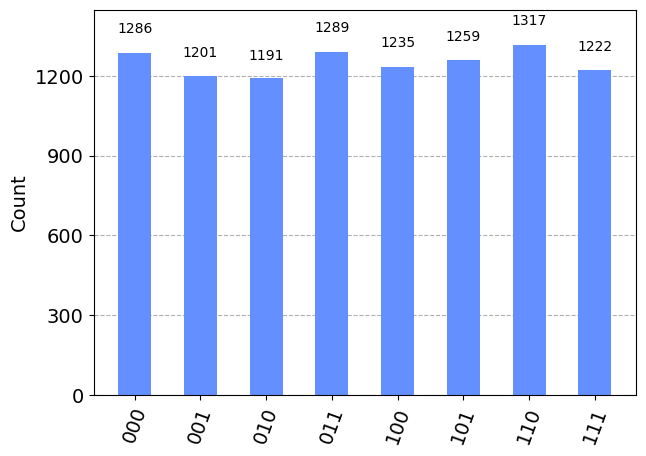

PROBABILIDAD DE ERROR:  0.95
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'cy', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


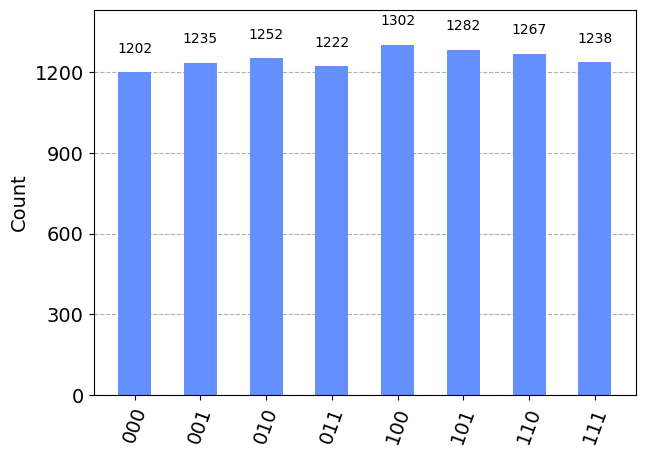

PROBABILIDAD DE ERROR:  1
noise model:  NoiseModel:
  Basis gates: ['cx', 'cy', 'cz', 'id', 'rz', 'sx']
  Instructions with noise: ['cx', 'cy', 'cz']
  All-qubits errors: ['cx', 'cy', 'cz']


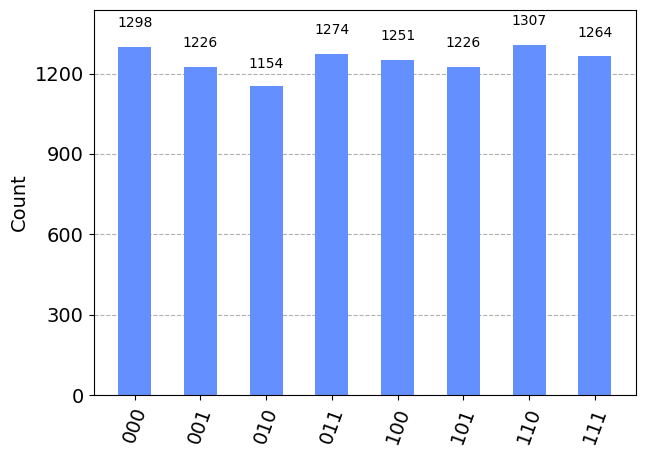

In [16]:
results = []
for i in errorProbabilities:
    #ALGORITMO
    print('PROBABILIDAD DE ERROR: ',i)
    
    noiseModel = NoiseModel()
    noiseModel = add_controlled_pauli_error(noiseModel,i/2,i/2,['cx','cy','cz'])
    basisGates=noiseModel.basis_gates
    print('noise model: ',noiseModel)
        
    qr = QuantumRegister(nroQubits)
    qc = QuantumCircuit(qr)
    qc.h(qr)
    qc.compose(groverOp.decompose(), inplace=True)
    qc.measure_all()
    #display(qc.draw("mpl"))
    #display(qc.data)
    
    #EJECUCION
    sim_noise = AerSimulator(noise_model=noiseModel)
    circ_tnoise = transpile(qc, sim_noise)
    result_bit_flip = sim_noise.run(circ_tnoise,shots=shots).result()
    counts_bit_flip = result_bit_flip.get_counts(0)
    display(plot_histogram(counts_bit_flip))
        
    results.append(counts_bit_flip)

In [17]:
#CALCULO DE PROBABILIDADES DE EXITO PARA CADA EXPERIMENTO
successCounts=[]
for i in results:
    currentCount = 0
    for j in marked_states:
        currentCount = currentCount + i[j]
    successCounts.append(currentCount/shots)
#print(successCounts)

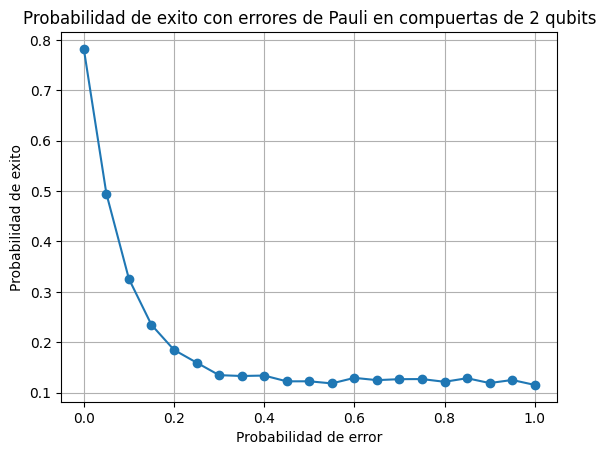

In [19]:
# Crear el gráfico
plt.plot(errorProbabilities, successCounts, marker='o', linestyle='-')

# Etiquetas de los ejes
plt.xlabel('Probabilidad de error')
plt.ylabel('Probabilidad de exito')

# Título del gráfico
plt.title('Probabilidad de exito con errores de Pauli en compuertas de 2 qubits')

# Mostrar el gráfico
plt.grid(True)
plt.show()